# 10_2.Two-Way mixed ANOVA(연습문제)
- https://pingouin-stats.org/build/html/generated/pingouin.mixed_anova.html#pingouin.mixed_anova

## 1.기본 package 설정

In [ ]:
# 그래프에서 한글 폰트 인식하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install pingouin

#  *** 런타임 다시 시작

In [1]:
# 1.기본
import numpy as np  # numpy 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기
import seaborn as sns # 시각화

# 2.데이터 가져오기
import pandas as pd # csv -> dataframe으로 전환

# 3.통계분석 package
import pingouin as pg
from scipy import stats
import statsmodels.api as sm

In [2]:
# 기본세팅
# 테마 설정
sns.set_theme(style = "darkgrid")

# 한글 인식
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # -인식

## 2.데이터 불러오기

### 2.1 데이터 프레임으로 저장
- 원본데이터(csv)를 dataframe 형태로 가져오기(pandas)

In [3]:
twma_df = pd.read_csv('https://raw.githubusercontent.com/leecho-bigdata/statistics-python/main/08_2.EEG.csv', encoding="cp949")
twma_df.head()

,id,성별,호흡,ch1,ch2
0,1,2,1,0.027,0.031
1,2,2,1,0.055,0.043
2,3,2,1,0.050,0.022
3,4,2,1,0.009,0.009
4,5,2,1,0.040,0.044


### 2.2 범주형 변수 처리
- 가변수 처리시 문자로 처리를 해야 변수명 구분이 쉬움

In [5]:
twma_df['성별'].replace({1:'남자', 2:'여자'}, inplace=True)
twma_df['호흡'].replace({1:'1_1', 2:'7_3', 3:'3_7'}, inplace=True)
twma_df['성별'] = twma_df['성별'].astype('category')
twma_df['호흡'] = twma_df['호흡'].astype('category')

twma_df.head()

,id,성별,호흡,ch1,ch2
0,1,여자,1_1,0.027,0.031
1,2,여자,1_1,0.055,0.043
2,3,여자,1_1,0.050,0.022
3,4,여자,1_1,0.009,0.009
4,5,여자,1_1,0.040,0.044


### 2.3 자료구조 살펴보기

In [6]:
twma_df.shape

(420, 5)

In [7]:
twma_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      420 non-null    int64   
 1   성별      420 non-null    category
 2   호흡      420 non-null    category
 3   ch1     420 non-null    float64 
 4   ch2     420 non-null    float64 
dtypes: category(2), float64(2), int64(1)
memory usage: 11.0 KB


In [8]:
twma_df.columns

Index(['id', '성별', '호흡', 'ch1', 'ch2'], dtype='object')

## 3.기술통계

In [9]:
# 그룹별 기술통계
twma_df.groupby(["성별","호흡"])["ch1"].describe().round(3)

count   mean    std    min    25%    50%    75%    max
성별 호흡                                                         
남자 1_1   38.0  0.044  0.029  0.004  0.029  0.038  0.050  0.166
   3_7   38.0  0.047  0.024  0.010  0.032  0.040  0.054  0.108
   7_3   38.0  0.045  0.021  0.004  0.031  0.042  0.060  0.099
여자 1_1  102.0  0.042  0.020  0.009  0.027  0.040  0.055  0.111
   3_7  102.0  0.048  0.022  0.016  0.033  0.044  0.057  0.136
   7_3  102.0  0.049  0.021  0.007  0.035  0.044  0.061  0.123

In [10]:
# 분석변수가 여러개 일 때
num_feature = ['ch1', 'ch2']
for num in num_feature:
    print("----", num, "----")
    results = twma_df.groupby(["성별","호흡"])[num].describe().round(3)
    print(results, "\n")

---- ch1 ----
        count   mean    std    min    25%    50%    75%    max
성별 호흡                                                         
남자 1_1   38.0  0.044  0.029  0.004  0.029  0.038  0.050  0.166
   3_7   38.0  0.047  0.024  0.010  0.032  0.040  0.054  0.108
   7_3   38.0  0.045  0.021  0.004  0.031  0.042  0.060  0.099
여자 1_1  102.0  0.042  0.020  0.009  0.027  0.040  0.055  0.111
   3_7  102.0  0.048  0.022  0.016  0.033  0.044  0.057  0.136
   7_3  102.0  0.049  0.021  0.007  0.035  0.044  0.061  0.123 

---- ch2 ----
        count   mean    std    min    25%    50%    75%    max
성별 호흡                                                         
남자 1_1   38.0  0.044  0.027  0.004  0.028  0.038  0.059  0.138
   3_7   38.0  0.052  0.025  0.024  0.036  0.044  0.062  0.112
   7_3   38.0  0.040  0.017  0.005  0.031  0.040  0.049  0.067
여자 1_1  102.0  0.039  0.016  0.009  0.026  0.038  0.048  0.110
   3_7  102.0  0.043  0.017  0.011  0.032  0.043  0.053  0.092
   7_3  102.0  0.050  0.0

## 4.TWM-ANOVA

### 4.1 상호작용효과 있을때

In [11]:
# 상호작용효과 있을때,
# 구형성일때: correction = False
pg.mixed_anova(dv = 'ch1',
               between = "성별",
               within = "호흡",
               subject='id',
               correction = False,
               data = twma_df).round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,성별,0.000,1,138,0.000,0.165,0.685,0.001,NaN
1,호흡,0.002,2,276,0.001,2.356,0.097,0.017,0.998
2,Interaction,0.000,2,276,0.000,0.372,0.689,0.003,NaN


In [12]:
# 구형성
pg.sphericity(dv = 'ch1',
              within = '호흡',
              subject = "id",
              data = twma_df)

/usr/local/lib/python3.10/dist-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


SpherResults(spher=True, W=inf, chi2=-inf, dof=2, pval=1.0)

In [15]:
# post-hoc test: 상호작용효과 있을때
# within_first = False: 성별 * 호흡
pg.pairwise_tests(dv = 'ch1',
                  between = "성별",
                  within = "호흡",
                  subject = 'id',
                  within_first = False,
                  data = twma_df).round(3)

,Contrast,성별,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,성별,-,여자,남자,False,True,0.361,54.144,two-sided,0.719,0.214,0.077
1,호흡,-,1_1,3_7,True,True,-1.904,139.000,two-sided,0.059,0.544,-0.229
2,호흡,-,1_1,7_3,True,True,-1.820,139.000,two-sided,0.071,0.468,-0.227
3,호흡,-,3_7,7_3,True,True,0.065,139.000,two-sided,0.948,0.094,0.008
4,성별 * 호흡,여자,1_1,3_7,True,True,-1.949,101.000,two-sided,0.054,0.675,-0.287
5,성별 * 호흡,여자,1_1,7_3,True,True,-2.059,101.000,two-sided,0.042,0.829,-0.309
6,성별 * 호흡,여자,3_7,7_3,True,True,-0.119,101.000,two-sided,0.906,0.11,-0.016
7,성별 * 호흡,남자,1_1,3_7,True,True,-0.501,37.000,two-sided,0.619,0.196,-0.105
8,성별 * 호흡,남자,1_1,7_3,True,True,-0.212,37.000,two-sided,0.833,0.178,-0.047
9,성별 * 호흡,남자,3_7,7_3,True,True,0.283,37.000,two-sided,0.779,0.181,0.069


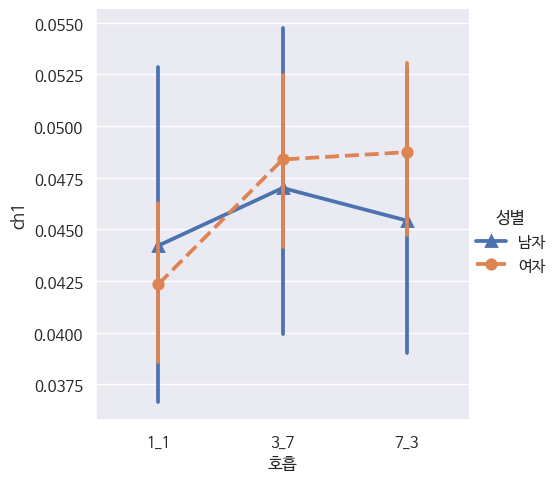

In [16]:
# 평균반응 프로파일 plot
sns.catplot(x = "호흡",
            y = "ch1",
            hue = "성별",
            markers = ["^", "o"],
            linestyles = ["-", "--"],
            kind = "point",
            data = twma_df)
plt.show()

### 4.2 상호작용효과 없을때, 그룹,호흡 모두 의미없을때

In [17]:
# 구형성일때: correction = False
pg.mixed_anova(dv = 'ch2',
               between = "성별",
               within = "호흡",
               subject='id',
               correction = False,
               data = twma_df).round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,성별,0.000,1,138,0.000,0.591,0.443,0.004,NaN
1,호흡,0.004,2,276,0.002,4.514,0.012,0.032,0.988
2,Interaction,0.005,2,276,0.003,6.596,0.002,0.046,NaN


In [18]:
# 구형성
pg.sphericity(dv = 'ch2',
              within = '호흡',
              subject = "id",
              data = twma_df)

/usr/local/lib/python3.10/dist-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


SpherResults(spher=True, W=inf, chi2=-inf, dof=2, pval=1.0)

In [19]:
# post-hoc test: 상호작용효과 있을때
# within_first = False: 성별 * 호흡
pg.pairwise_tests(dv = 'ch2',
                  between = "성별",
                  within = "호흡",
                  subject = 'id',
                  within_first = False,
                  data = twma_df).round(3)

,Contrast,성별,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,성별,-,여자,남자,False,True,-0.685,54.437,two-sided,0.496,0.249,-0.145
1,호흡,-,1_1,3_7,True,True,-2.317,139.000,two-sided,0.022,1.245,-0.270
2,호흡,-,1_1,7_3,True,True,-2.798,139.000,two-sided,0.006,3.938,-0.326
3,호흡,-,3_7,7_3,True,True,-0.566,139.000,two-sided,0.572,0.11,-0.070
4,성별 * 호흡,여자,1_1,3_7,True,True,-1.921,101.000,two-sided,0.058,0.64,-0.276
5,성별 * 호흡,여자,1_1,7_3,True,True,-3.947,101.000,two-sided,0.000,128.496,-0.553
6,성별 * 호흡,여자,3_7,7_3,True,True,-2.369,101.000,two-sided,0.020,1.569,-0.318
7,성별 * 호흡,남자,1_1,3_7,True,True,-1.317,37.000,two-sided,0.196,0.387,-0.284
8,성별 * 호흡,남자,1_1,7_3,True,True,0.923,37.000,two-sided,0.362,0.26,0.184
9,성별 * 호흡,남자,3_7,7_3,True,True,2.140,37.000,two-sided,0.039,1.334,0.551


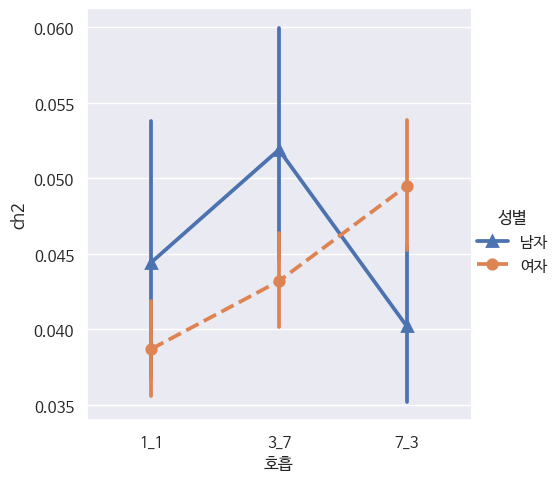

In [20]:
# 평균반응 프로파일 plot
sns.catplot(x = "호흡",
            y = "ch2",
            hue = "성별",
            markers = ["^", "o"],
            linestyles = ["-", "--"],
            kind = "point",
            data = twma_df)
plt.show()